# Problem Formulation for Tradespace Exploration using Rhodium

This notebook describes potential approaches of transforming the original problem formulation into ones which can better utilize functionalities provided by Rhodium.

## Problem Defination:
Finding the set of pareto equivalent policies in optimizing performance, cost, and risk, given an understanding of the requirements and constraints. 

In [1]:
from rhodium import *
import json
import math
from scipy.optimize import brentq as root
from j3 import J3
import numpy as np
import itertools
import csv

# plotting options
%matplotlib inline
sns.set()
sns.set_style('darkgrid')

## Approach 1: Enumeration without uncertainty
In this approach, we define a model which maps each decision alternative to a set of predefined metrics. The model takes in 10 lever parameters representing 10 decisions and returns a set of weighted sum of the metrics for the given policy.
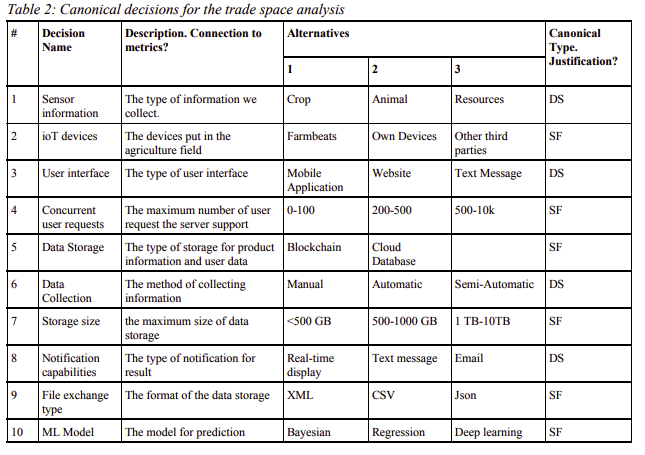

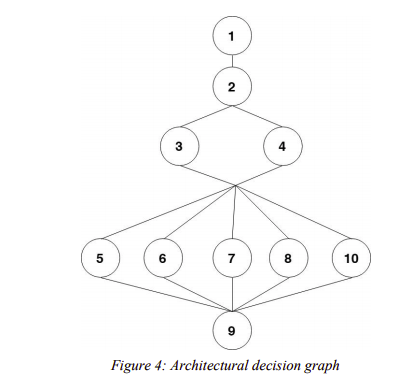

In [2]:
decisions = []
# with open("decisions.json", "r") as read_file:
    
read = open("decisions.json", "r")
decisions = json.load(read)['Decisions']
read.close()
    
print(decisions[0])

{'description': 'sensor information', 'type': 'DS', 'importance': 4, 'decisions': [{'alternative': 'Crop', 'performance': 1.05, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Animal', 'performance': 1.08, 'KLOC': 1500, 'cost': 0, 'risk': 0}, {'alternative': 'Resources', 'performance': 1.1, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Animal', 'performance': 1.1, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Animal&Resources', 'performance': 1.15, 'KLOC': 1500, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Resources', 'performance': 1.14, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Resources&Animal', 'performance': 1.2, 'KLOC': 5000, 'cost': 0, 'risk': 0}]}


In [3]:
def farm_approach1(D1, D2, D3, D4, D5, D6, D7, D8, D9, D10):
    #policy = [D1[0], D2, D3[0], D4, D5, D6[0], D7, D8[0], D9, D10]
    policy = [D1, D2, D3, D4, D5, D6, D7, D8, D9, D10]
    performance = 1
    
    for i in range(9):
        performance *= decisions[i]['decisions'][policy[i]]['performance'] #* decisions[i]['importance']
    
    IoT_cost = decisions[1]['decisions'][D2]['cost']

    UI_cost = decisions[2]['decisions'][D3]['cost'] 
    
    DataStorage_cost = decisions[4]['decisions'][D5]['cost']
    
    ML_risk = decisions[9]['decisions'][D10]['risk']
    DataStorage_risk = decisions[4]['decisions'][D5]['risk']
    
    cost = IoT_cost + UI_cost + DataStorage_cost
    risk = ML_risk + DataStorage_risk
    
    return (performance, cost, risk)

In [4]:
model = Model(farm_approach1)

model.parameters = [Parameter("D1"),
                    Parameter("D2"),
                    Parameter("D3"),
                    Parameter("D4"),
                    Parameter("D5"),
                    Parameter("D6"),
                    Parameter("D7"),
                    Parameter("D8"),
                    Parameter("D9"),
                    Parameter("D10")]

model.responses = [Response("performance", Response.MAXIMIZE),
                   Response("cost", Response.MINIMIZE),
                   Response("risk", Response.MINIMIZE)]
model.constraints = []

DS_choices = [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]
SF_choices = [0, 1, 2]

model.levers = [IntegerLever("D1", 0, 6, 1),
                IntegerLever("D2", 0, 2, 1),
                IntegerLever("D3", 0, 6, 1),
                IntegerLever("D4", 0, 2, 1),
                IntegerLever("D5", 0, 1, 1),
                IntegerLever("D6", 0, 6, 1),
                IntegerLever("D7", 0, 2, 1),
                IntegerLever("D8", 0, 6, 1),
                IntegerLever("D9", 0, 2, 1),
                IntegerLever("D10", 0, 2, 1)]

In [5]:
output = optimize(model, "NSGAII", 100)
print("Found", len(output), "optimal policies!")
print(output)

here
Found 13 optimal policies!
Index 0:
    D1: 2
    D2: 0
    D3: 4
    D4: 0
    D5: 1
    D6: 0
    D7: 0
    D8: 3
    D9: 0
    D10: 1
    performance: 42.8835
    cost: 235500
    risk: 0.1009
Index 1:
    D1: 0
    D2: 0
    D3: 2
    D4: 1
    D5: 0
    D6: 5
    D7: 2
    D8: 6
    D9: 1
    D10: 1
    performance: 22.2060283137
    cost: 255500
    risk: 0.10005
Index 2:
    D1: 6
    D2: 0
    D3: 3
    D4: 0
    D5: 1
    D6: 4
    D7: 2
    D8: 0
    D9: 1
    D10: 1
    performance: 115.64510399999998
    cost: 330500
    risk: 0.1009
Index 3:
    D1: 4
    D2: 0
    D3: 4
    D4: 1
    D5: 1
    D6: 6
    D7: 2
    D8: 5
    D9: 0
    D10: 2
    performance: 75.07961311499997
    cost: 235500
    risk: 0.20090000000000002
Index 4:
    D1: 1
    D2: 1
    D3: 6
    D4: 2
    D5: 0
    D6: 6
    D7: 2
    D8: 3
    D9: 2
    D10: 1
    performance: 39.220678224000004
    cost: 387000
    risk: 0.10005
Index 5:
    D1: 0
    D2: 0
    D3: 4
    D4: 0
    D5: 0
    D6: 5
 

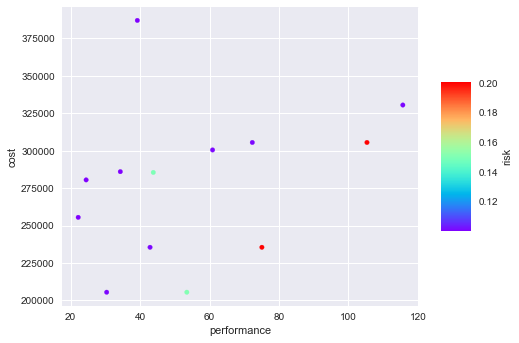

In [6]:
fig = scatter2d(model, output)

In [ ]:
fig = parallel_coordinates(model, output, colormap="rainbow", target="top")

In [ ]:
output.as_dataframe(['performance', 'cost', 'risk']).to_csv(r'results.csv')

## Approach 2: Enumeration with some uncertainties
In addtion to the 10 lever parameters defined in Approach 1, more parameters that are key to the system can be introduced, such as farm area, farm type, etc. These added parameters may involve uncertainties. Then, the model of this approad need to calculate metrics of decisions based on these new factors.

In [63]:
def farm_approach2(D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, 
                   numOfUsers = 1000,
                   latitude = 42.44):

    policy = [D1, D2, D3, D4, D5, D6, D7, D8, D9, D10]
    performance = 1
    
    #Account for latitude changes
    decisions[5]['decisions'][policy[5]]['performance'] *= (1 - (latitude/1000))
    decisions[2]['decisions'][policy[2]]['performance'] *= (1 - (latitude/1000))
    
    for i in range(9):
        performance *= decisions[i]['decisions'][policy[i]]['performance']
    
    IoT_cost = decisions[1]['decisions'][D2]['cost']

    UI_cost = decisions[2]['decisions'][D3]['cost'] 
    
    DataStorage_cost = decisions[4]['decisions'][D5]['cost']
    
    ML_risk = decisions[9]['decisions'][D10]['risk']
    DataStorage_risk = decisions[4]['decisions'][D5]['risk']
    
    matainance_cost = IoT_cost + (UI_cost + DataStorage_cost)/numOfUsers
    hardware_cost = IoT_cost * numOfUsers
    
    cost = matainance_cost + hardware_cost
    risk = ML_risk + DataStorage_risk
    
    return (performance, cost, risk)

In [64]:
model = Model(farm_approach2)

model.parameters = [Parameter("D1"),
                    Parameter("D2"),
                    Parameter("D3"),
                    Parameter("D4"),
                    Parameter("D5"),
                    Parameter("D6"),
                    Parameter("D7"),
                    Parameter("D8"),
                    Parameter("D9"),
                    Parameter("D10"),
                    Parameter("numOfUsers"),
                    Parameter("latitude")]

model.responses = [Response("performance", Response.MAXIMIZE),
                   Response("cost", Response.MINIMIZE),
                   Response("risk", Response.MINIMIZE)]
model.constraints = []

model.levers = [IntegerLever("D1", 0, 6, 1),
                IntegerLever("D2", 0, 2, 1),
                IntegerLever("D3", 0, 6, 1),
                IntegerLever("D4", 0, 2, 1),
                IntegerLever("D5", 0, 1, 1),
                IntegerLever("D6", 0, 6, 1),
                IntegerLever("D7", 0, 2, 1),
                IntegerLever("D8", 0, 6, 1),
                IntegerLever("D9", 0, 2, 1),
                IntegerLever("D10", 0, 2, 1)]

In [65]:
output = optimize(model, "NSGAII", 100)
print("Found", len(output), "optimal policies!")

output.as_dataframe(['performance', 'cost', 'risk']).to_csv(r'results.csv')

here
Found 8 optimal policies!


#### Scenario Discovery & SOW


In [66]:
model.uncertainties = [NormalUncertainty("numOfUsers", 1000, 100),
                       NormalUncertainty("latitude", 40, 3)]

In [67]:
policy = {"D1" : 4,"D2":0, "D3":3, "D4":1, "D5":0, "D6":4, "D7":2, "D8":4, "D9":0, "D10":0}
result = evaluate(model, policy)
print(result)

{'D1': 4, 'D2': 0, 'D3': 3, 'D4': 1, 'D5': 0, 'D6': 4, 'D7': 2, 'D8': 4, 'D9': 0, 'D10': 0, 'performance': inf, 'cost': 500880.0, 'risk': 0.15005}


In [68]:
SOWs = sample_lhs(model, 1000)
print(SOWs)

Index 0:
    numOfUsers: 1100.25783943
    latitude: 41.1832993087
Index 1:
    numOfUsers: 914.183928289
    latitude: 37.4305678064
Index 2:
    numOfUsers: 1004.57869085
    latitude: 37.2380173673
Index 3:
    numOfUsers: 925.409877877
    latitude: 35.8873658304
Index 4:
    numOfUsers: 982.770654145
    latitude: 40.791907823
Index 5:
    numOfUsers: 965.112941703
    latitude: 39.1554501967
Index 6:
    numOfUsers: 1164.76935966
    latitude: 41.8546230704
Index 7:
    numOfUsers: 984.458208257
    latitude: 41.8706846132
Index 8:
    numOfUsers: 1001.16120405
    latitude: 34.4801047076
Index 9:
    numOfUsers: 958.902171359
    latitude: 35.0019480459
Index 10:
    numOfUsers: 1027.48044089
    latitude: 37.2906756217
Index 11:
    numOfUsers: 877.689237656
    latitude: 42.1099137713
Index 12:
    numOfUsers: 957.155369069
    latitude: 36.8023235452
Index 13:
    numOfUsers: 838.045190779
    latitude: 45.6537602137
Index 14:
    numOfUsers: 926.679748688
    latitude: 46.94

In [69]:
results = evaluate(model, update(SOWs, policy))
print(results)

Index 0:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 1100.25783943
    latitude: 41.1832993087
    performance: inf
    cost: 550974.293305
    risk: 0.15005
Index 1:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 914.183928289
    latitude: 37.4305678064
    performance: inf
    cost: 458007.635421
    risk: 0.15005
Index 2:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 1004.57869085
    latitude: 37.2380173673
    performance: inf
    cost: 503167.613452
    risk: 0.15005
Index 3:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 925.409877877
    latitude: 35.8873658304
    performance: inf
    cost: 463615.567795
    risk: 0.15005
Index 4:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7:

In [70]:
results.as_dataframe(['performance', 'cost', 'numOfUsers', 'latitude']).to_csv(r'SD_results.csv')

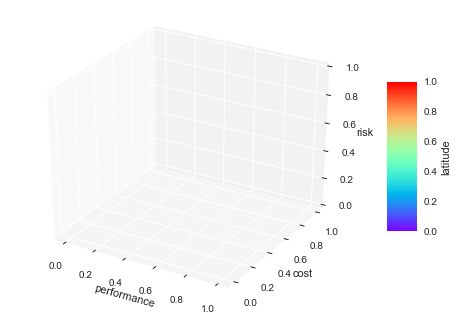

In [71]:
plot3fig = scatter3d(model, results, c = 'latitude', s = 'numOfUsers')

In [74]:
classification = results.apply("'Effective' if performance > 2 else 'Ineffective'")

In [75]:
p = Prim(results, classification, include=model.uncertainties.keys(), coi="Effective")
box = p.find_box()
fig = box.show_tradeoff()

/Users/zhaoyifan/Desktop/farmVal/PRIM/prim/prim_alg.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (False not in unique_y and True not in unique_y)):


ZeroDivisionError: float division by zero

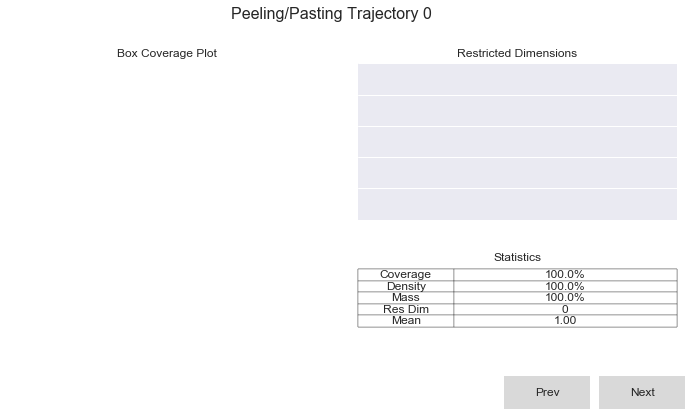

In [45]:
box.show_details()
plt.show()

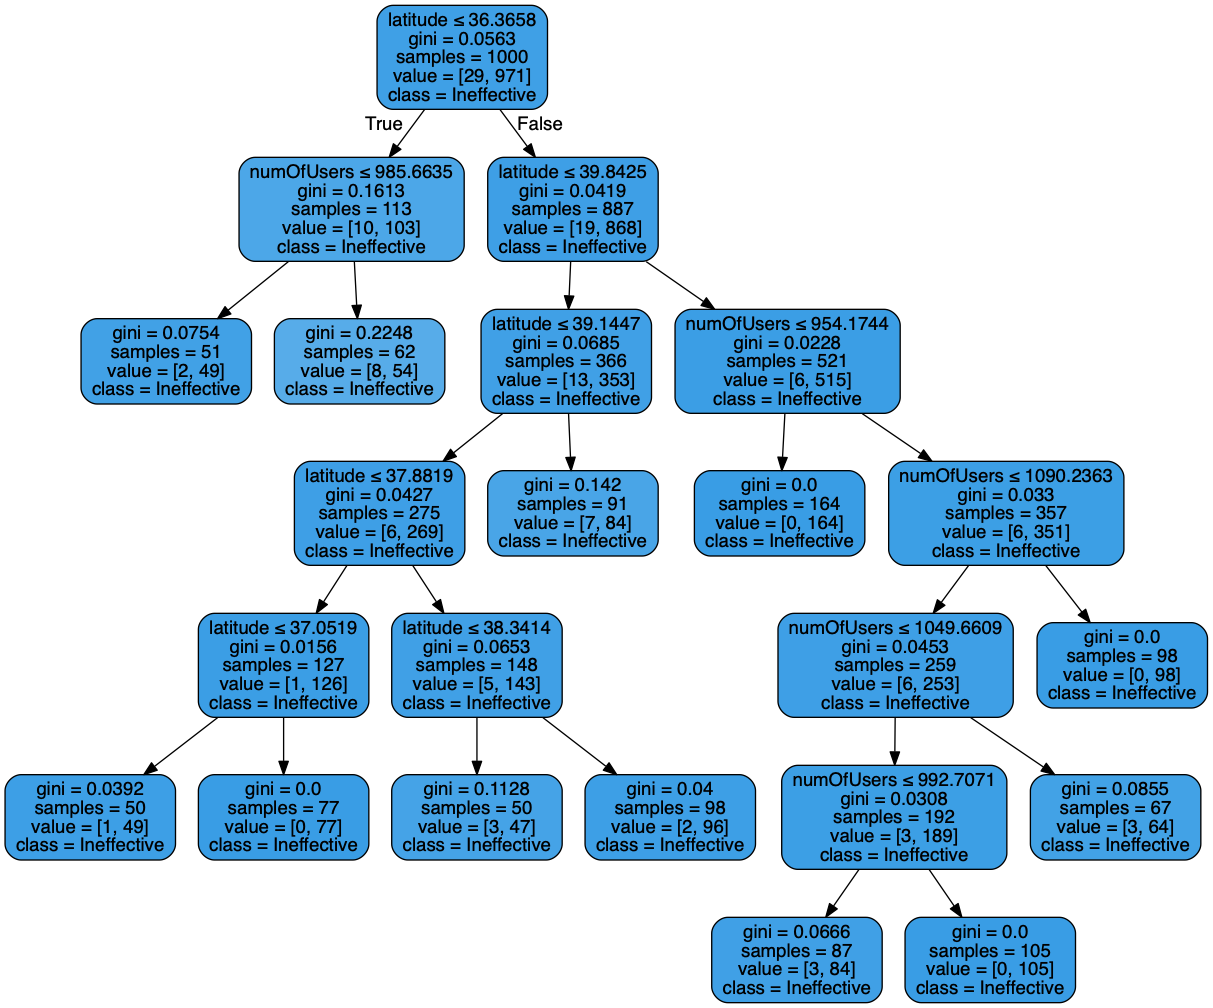

In [17]:
c = Cart(results, classification, include=model.uncertainties.keys(), min_samples_leaf=50)
c.show_tree()